# 06.02 Feature Selection

## Imports & setup

In [1]:
import pathlib
from datetime import datetime
import math
import sys

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from skoot.feature_selection import FeatureFilter
from skoot.preprocessing import SelectiveRobustScaler

sys.path.append("..")
from src.models.models import SetTempAsPower, SK_Prophet
from src.utils.utils import bound_precision, AnnualTimeSeriesSplit
from src.visualization.visualize import (plot_prediction,
                                         plot_joint_plot,
                                         residual_plots,
                                         print_residual_stats,
                                         seasonal_plot)

%matplotlib inline

PROJECT_DIR = pathlib.Path.cwd().parent.resolve()
CLEAN_DATA_DIR = PROJECT_DIR / 'data' / '05-clean'
NOTEBOOKS_DIR = PROJECT_DIR / 'notebooks'

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Load Daily Data

In [2]:
df_orig = pd.read_csv(CLEAN_DATA_DIR / 'daily.csv', index_col=0, parse_dates=True)
df_orig.head()

,temp_min,temp_max,temp_mean,temp_median,temp_max_hour,temp_min_hour,dew_point_temp_min,dew_point_temp_max,dew_point_temp_mean,dew_point_temp_median,dew_point_temp_max_hour,dew_point_temp_min_hour,rel_hum_min,rel_hum_max,rel_hum_mean,rel_hum_median,rel_hum_max_hour,rel_hum_min_hour,visibility_min,visibility_max,visibility_mean,visibility_median,visibility_max_hour,visibility_min_hour,press_min,press_max,press_mean,press_median,press_max_hour,press_min_hour,hmdxx_min,hmdxx_max,hmdxx_mean,hmdxx_median,hmdxx_max_hour,hmdxx_min_hour,sun_set,sun_rise,hmdxx_median-1,day_of_week,week_of_year,workday_before_stat_hol,workday_after_stat_hol,daily_peak,year
1994-05-24,9.0,19.6,14.300000,14.60,12.0,3.0,6.2,13.4,9.508333,8.95,18.0,11.0,42.0,92.0,75.083333,81.0,22.0,12.0,6.4,40.2,24.975000,24.55,5.0,8.0,98.52,99.39,99.045000,99.155,9.0,23.0,8.998045,19.818202,15.440330,17.205396,15.0,4.0,21.0,6.0,19.655075,1.0,21.0,0,1,16173.0,1994.0
1994-05-25,10.4,18.2,14.491667,14.95,16.0,2.0,9.4,14.0,11.825000,12.25,18.0,1.0,64.0,96.0,84.666667,87.0,2.0,16.0,6.4,12.9,9.358333,9.70,15.0,5.0,98.26,98.46,98.353125,98.360,0.0,17.0,11.406291,20.665711,16.695849,17.722172,18.0,3.0,21.0,6.0,17.205396,2.0,21.0,0,0,16017.0,1994.0
1994-05-26,3.9,13.0,8.037500,7.00,0.0,20.0,1.9,12.3,6.729167,5.80,5.0,22.0,81.0,97.0,91.416667,91.5,5.0,22.0,4.8,24.1,9.650000,8.85,23.0,5.0,97.89,99.09,98.295000,98.125,21.0,6.0,2.563201,15.259916,8.102568,6.567827,2.0,17.0,21.0,6.0,17.722172,3.0,21.0,0,0,16656.0,1994.0
1994-05-27,2.0,14.8,8.712500,8.70,16.0,3.0,-0.9,2.3,0.562500,0.40,14.0,15.0,36.0,95.0,59.833333,54.5,1.0,15.0,25.0,40.2,34.500000,40.20,5.0,0.0,99.12,99.52,99.392083,99.450,9.0,0.0,-0.012865,12.970553,6.695368,6.599016,17.0,3.0,21.0,6.0,6.567827,4.0,21.0,0,0,16252.0,1994.0
1994-05-30,13.1,27.2,20.850000,21.70,15.0,3.0,8.0,13.6,11.225000,12.40,14.0,5.0,40.0,74.0,55.375000,52.5,1.0,15.0,16.1,25.0,22.270833,24.10,0.0,1.0,99.39,99.62,99.519583,99.535,8.0,20.0,13.632519,30.133976,22.777217,23.590459,14.0,3.0,21.0,6.0,18.724332,0.0,22.0,0,0,16525.0,1994.0


In [3]:
df_cut = df_orig.copy(deep=True)

df_cut = df_cut.loc['1994': '1998']
y = df_cut.pop('daily_peak')
X = df_cut
X.head()

,temp_min,temp_max,temp_mean,temp_median,temp_max_hour,temp_min_hour,dew_point_temp_min,dew_point_temp_max,dew_point_temp_mean,dew_point_temp_median,dew_point_temp_max_hour,dew_point_temp_min_hour,rel_hum_min,rel_hum_max,rel_hum_mean,rel_hum_median,rel_hum_max_hour,rel_hum_min_hour,visibility_min,visibility_max,visibility_mean,visibility_median,visibility_max_hour,visibility_min_hour,press_min,press_max,press_mean,press_median,press_max_hour,press_min_hour,hmdxx_min,hmdxx_max,hmdxx_mean,hmdxx_median,hmdxx_max_hour,hmdxx_min_hour,sun_set,sun_rise,hmdxx_median-1,day_of_week,week_of_year,workday_before_stat_hol,workday_after_stat_hol,year
1994-05-24,9.0,19.6,14.300000,14.60,12.0,3.0,6.2,13.4,9.508333,8.95,18.0,11.0,42.0,92.0,75.083333,81.0,22.0,12.0,6.4,40.2,24.975000,24.55,5.0,8.0,98.52,99.39,99.045000,99.155,9.0,23.0,8.998045,19.818202,15.440330,17.205396,15.0,4.0,21.0,6.0,19.655075,1.0,21.0,0,1,1994.0
1994-05-25,10.4,18.2,14.491667,14.95,16.0,2.0,9.4,14.0,11.825000,12.25,18.0,1.0,64.0,96.0,84.666667,87.0,2.0,16.0,6.4,12.9,9.358333,9.70,15.0,5.0,98.26,98.46,98.353125,98.360,0.0,17.0,11.406291,20.665711,16.695849,17.722172,18.0,3.0,21.0,6.0,17.205396,2.0,21.0,0,0,1994.0
1994-05-26,3.9,13.0,8.037500,7.00,0.0,20.0,1.9,12.3,6.729167,5.80,5.0,22.0,81.0,97.0,91.416667,91.5,5.0,22.0,4.8,24.1,9.650000,8.85,23.0,5.0,97.89,99.09,98.295000,98.125,21.0,6.0,2.563201,15.259916,8.102568,6.567827,2.0,17.0,21.0,6.0,17.722172,3.0,21.0,0,0,1994.0
1994-05-27,2.0,14.8,8.712500,8.70,16.0,3.0,-0.9,2.3,0.562500,0.40,14.0,15.0,36.0,95.0,59.833333,54.5,1.0,15.0,25.0,40.2,34.500000,40.20,5.0,0.0,99.12,99.52,99.392083,99.450,9.0,0.0,-0.012865,12.970553,6.695368,6.599016,17.0,3.0,21.0,6.0,6.567827,4.0,21.0,0,0,1994.0
1994-05-30,13.1,27.2,20.850000,21.70,15.0,3.0,8.0,13.6,11.225000,12.40,14.0,5.0,40.0,74.0,55.375000,52.5,1.0,15.0,16.1,25.0,22.270833,24.10,0.0,1.0,99.39,99.62,99.519583,99.535,8.0,20.0,13.632519,30.133976,22.777217,23.590459,14.0,3.0,21.0,6.0,18.724332,0.0,22.0,0,0,1994.0


## Humidex

This is my favourite because it is incorporates Temperature, and Dewpoint Temperature

Therefore, I will drop Temperature, and Dew Point Temperature and keep Humidex

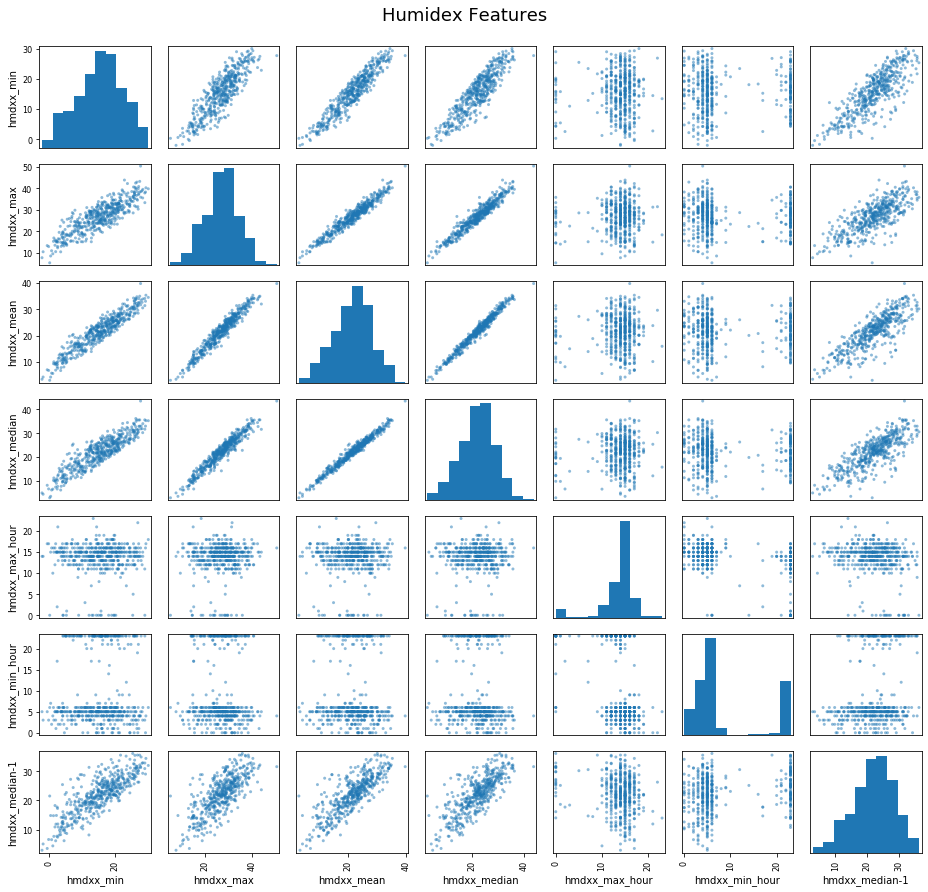

In [4]:
hmdxx_cols = [col for col in X.columns if 'hmdxx' in col[0:10]]
X_hmdxx = X[hmdxx_cols]
pd.plotting.scatter_matrix(X_hmdxx, figsize=(13,13));
plt.suptitle('Humidex Features', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(NOTEBOOKS_DIR / 'saved-images' / 'humidex-features-correlation-plot.PNG')
plt.show();

/home/david/anaconda3/envs/ana_py37tf/lib/python3.7/site-packages/yellowbrick/features/rankd.py:215: YellowbrickWarning:

RankD plots may be clipped when using matplotlib v3.1.1, upgrade to matplotlib v3.1.2 or later to fix the plots.



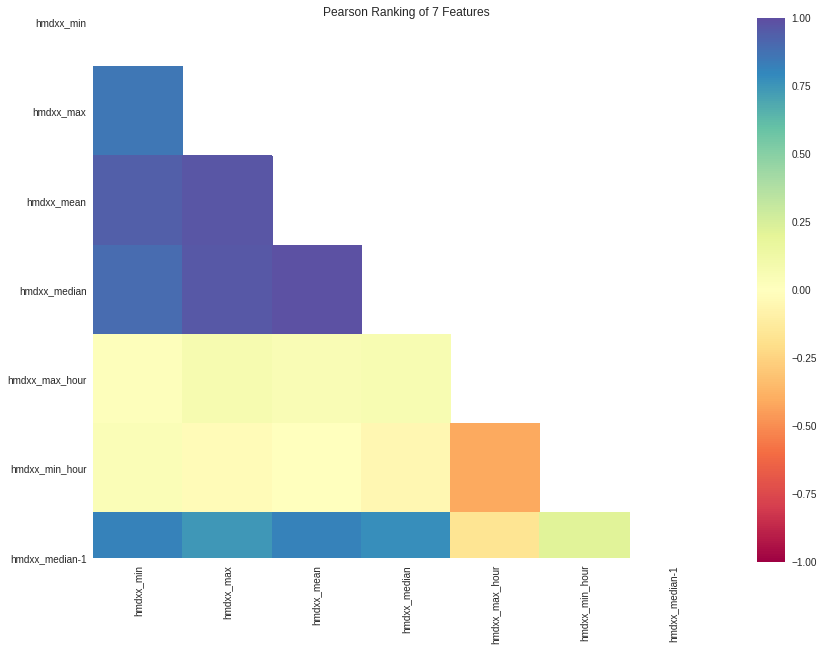

In [5]:
from yellowbrick.features import Rank2D
# Instantiate visualizer using Pearson ranking algorithm
figsize=(14, 10)
fig, ax = plt.subplots(figsize=figsize)
visualizer = Rank2D(features=hmdxx_cols, algorithm='pearson', colormap='Spectral')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

visualizer.fit(X_hmdxx, y)
visualizer.transform(X_hmdxx)
visualizer.poof();

In [6]:
corr = X_hmdxx.corr()
corr.head(40)

,hmdxx_min,hmdxx_max,hmdxx_mean,hmdxx_median,hmdxx_max_hour,hmdxx_min_hour,hmdxx_median-1
hmdxx_min,1.000000,0.853355,0.940887,0.893759,0.020110,0.039685,0.814698
hmdxx_max,0.853355,1.000000,0.969449,0.962857,0.074745,-0.030827,0.742815
hmdxx_mean,0.940887,0.969449,1.000000,0.986532,0.046984,0.003956,0.813352
hmdxx_median,0.893759,0.962857,0.986532,1.000000,0.065830,-0.049782,0.776900
hmdxx_max_hour,0.020110,0.074745,0.046984,0.065830,1.000000,-0.411127,-0.171609
hmdxx_min_hour,0.039685,-0.030827,0.003956,-0.049782,-0.411127,1.000000,0.213156
hmdxx_median-1,0.814698,0.742815,0.813352,0.776900,-0.171609,0.213156,1.000000


Explain later, but let's keep these
+ Humidex Maximum `hmdxx_max`
+ Humidex Median `hmdxx_median`
+ Humidex Range `hmdxx_max - hmdxx_min`
+ Humidex Max Hour `hmdxx_max_hour`
+ Humidex Min Hour `hmdxx_min_hour`
+ Previous Day's Median Humidex `hmdxx_median-1`

### Relationship to Power Demand

In [7]:
XP_hmdxx = pd.concat([X_hmdxx, y], axis=1)
XP_hmdxx.head()

,hmdxx_min,hmdxx_max,hmdxx_mean,hmdxx_median,hmdxx_max_hour,hmdxx_min_hour,hmdxx_median-1,daily_peak
1994-05-24,8.998045,19.818202,15.440330,17.205396,15.0,4.0,19.655075,16173.0
1994-05-25,11.406291,20.665711,16.695849,17.722172,18.0,3.0,17.205396,16017.0
1994-05-26,2.563201,15.259916,8.102568,6.567827,2.0,17.0,17.722172,16656.0
1994-05-27,-0.012865,12.970553,6.695368,6.599016,17.0,3.0,6.567827,16252.0
1994-05-30,13.632519,30.133976,22.777217,23.590459,14.0,3.0,18.724332,16525.0


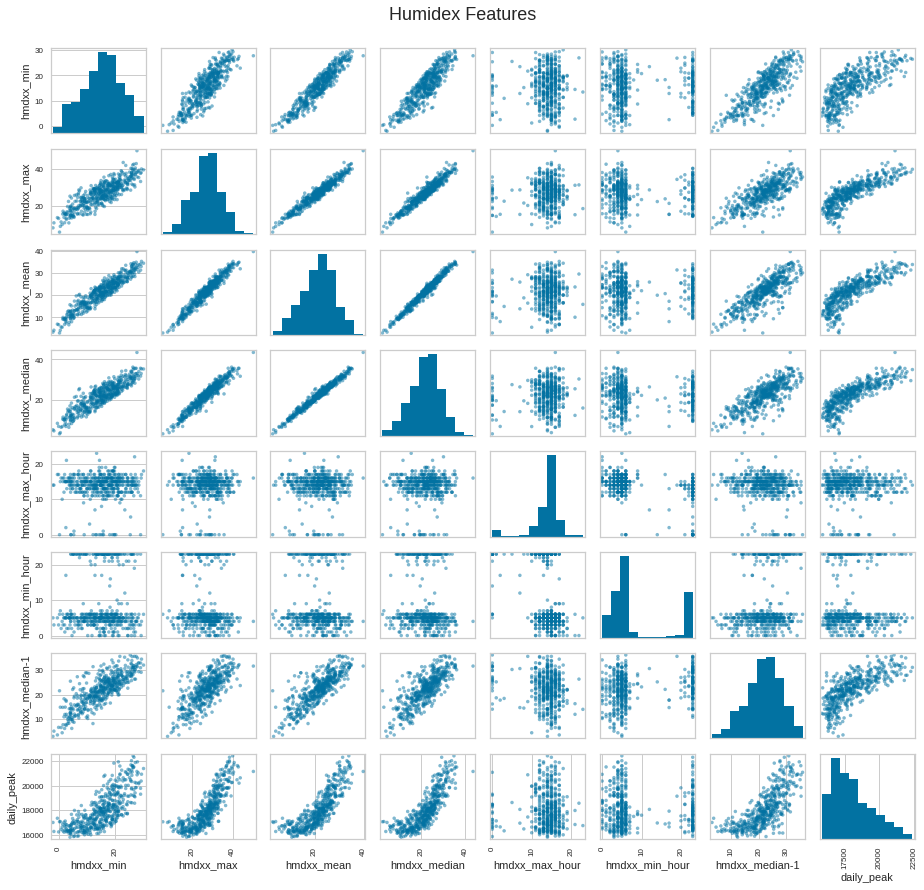

In [8]:
pd.plotting.scatter_matrix(XP_hmdxx, figsize=(13,13));
plt.suptitle('Humidex Features', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.savefig(NOTEBOOKS_DIR / 'saved-images' / 'humidex-features-correlation-plot.PNG')
plt.show();

In [9]:
corr = XP_hmdxx.corr()
corr.head(40)

,hmdxx_min,hmdxx_max,hmdxx_mean,hmdxx_median,hmdxx_max_hour,hmdxx_min_hour,hmdxx_median-1,daily_peak
hmdxx_min,1.000000,0.853355,0.940887,0.893759,0.020110,0.039685,0.814698,0.751097
hmdxx_max,0.853355,1.000000,0.969449,0.962857,0.074745,-0.030827,0.742815,0.825540
hmdxx_mean,0.940887,0.969449,1.000000,0.986532,0.046984,0.003956,0.813352,0.827657
hmdxx_median,0.893759,0.962857,0.986532,1.000000,0.065830,-0.049782,0.776900,0.819924
hmdxx_max_hour,0.020110,0.074745,0.046984,0.065830,1.000000,-0.411127,-0.171609,0.016289
hmdxx_min_hour,0.039685,-0.030827,0.003956,-0.049782,-0.411127,1.000000,0.213156,-0.011978
hmdxx_median-1,0.814698,0.742815,0.813352,0.776900,-0.171609,0.213156,1.000000,0.733112
daily_peak,0.751097,0.825540,0.827657,0.819924,0.016289,-0.011978,0.733112,1.000000


It is difficult to pick out 

Keep hmdxx_min, hmdxx_max, hmdxx_median-1, hmdxx_max_hour

## Temperature Features

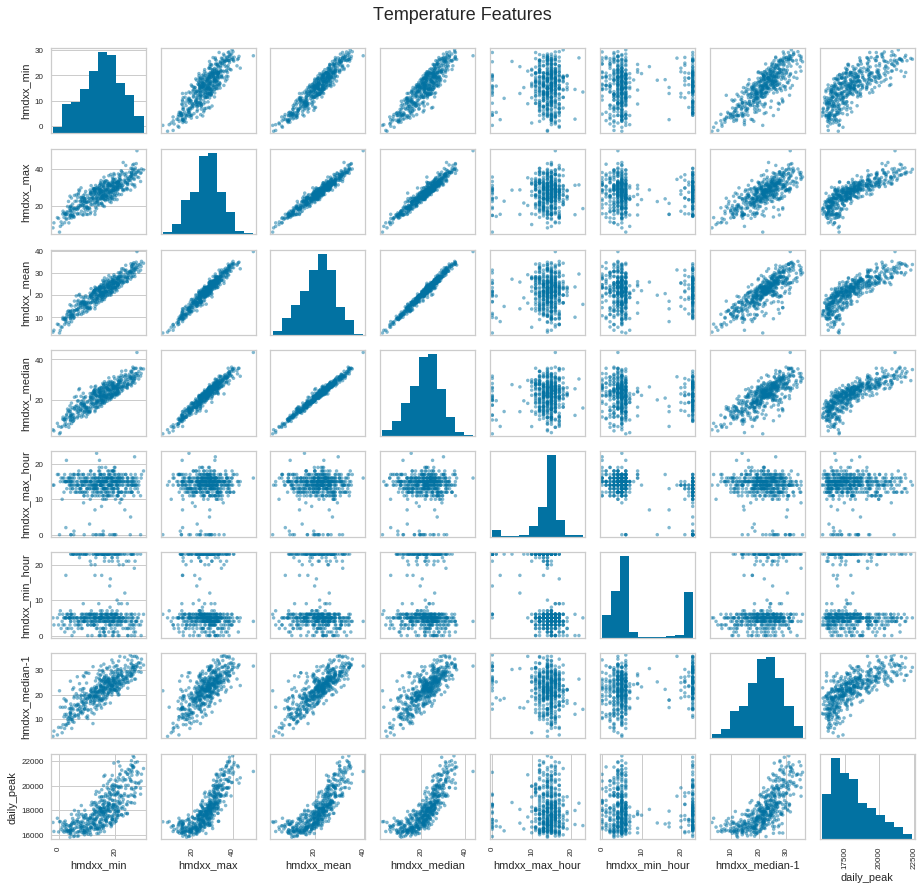

In [10]:
temp_cols = [col for col in X.columns if 'temp' in col[0:10]]
X_temp = X[temp_cols]
XP_temp = pd.concat([X_hmdxx, y], axis=1)
pd.plotting.scatter_matrix(XP_temp, figsize=(13,13));
plt.suptitle('Temperature Features', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.savefig(NOTEBOOKS_DIR / 'saved-images' / 'humidex-features-correlation-plot.PNG')
plt.show();

keep temp_max, temp_min

## Dew Point Temperature Features

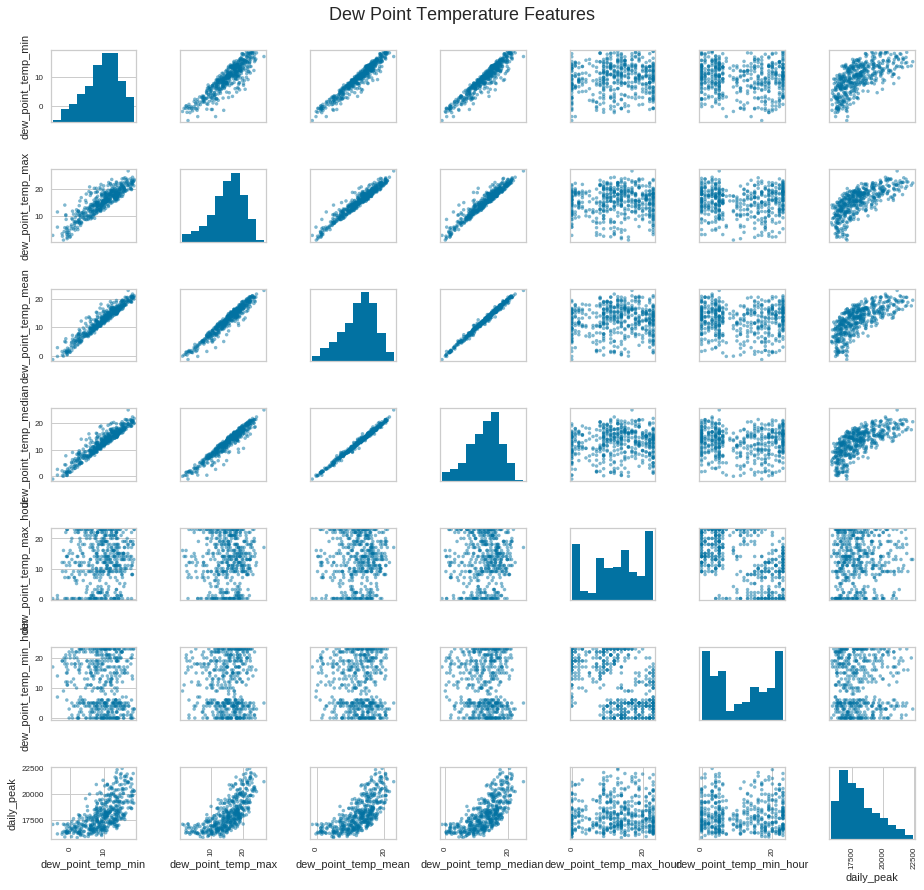

In [11]:
dp_temp_cols = [col for col in X.columns if 'dew_point_temp' in col]
X_temp = X[dp_temp_cols]
XP_temp = pd.concat([X_temp, y], axis=1)
pd.plotting.scatter_matrix(XP_temp, figsize=(13,13));
plt.suptitle('Dew Point Temperature Features', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.savefig(NOTEBOOKS_DIR / 'saved-images' / 'humidex-features-correlation-plot.PNG')
plt.show();

Keep dew point temp_max

## Visibility Features

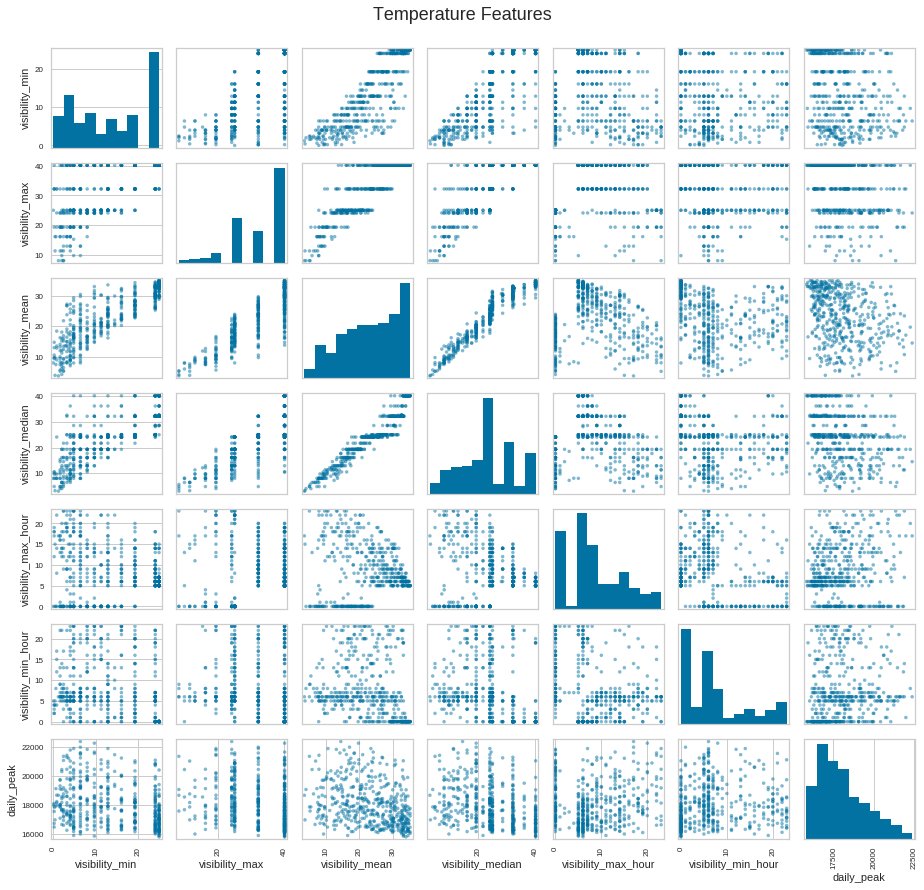

In [12]:
dp_temp_cols = [col for col in X.columns if 'visibility' in col]
X_temp = X[dp_temp_cols]
XP_temp = pd.concat([X_temp, y], axis=1)
pd.plotting.scatter_matrix(XP_temp, figsize=(13,13));
plt.suptitle('Temperature Features', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.savefig(NOTEBOOKS_DIR / 'saved-images' / 'humidex-features-correlation-plot.PNG')
plt.show();

Keep visibility_min_hour

## Relative Humidity

https://www.idt.com/blogs/understanding-relative-humidity-and-dew-point


It seems there is a relationship between relative humidity and dew point temperature, which is dependent on 

This article says dew point is a far better measurement which we have captured in our humidex

So neglect RH

## Pressure

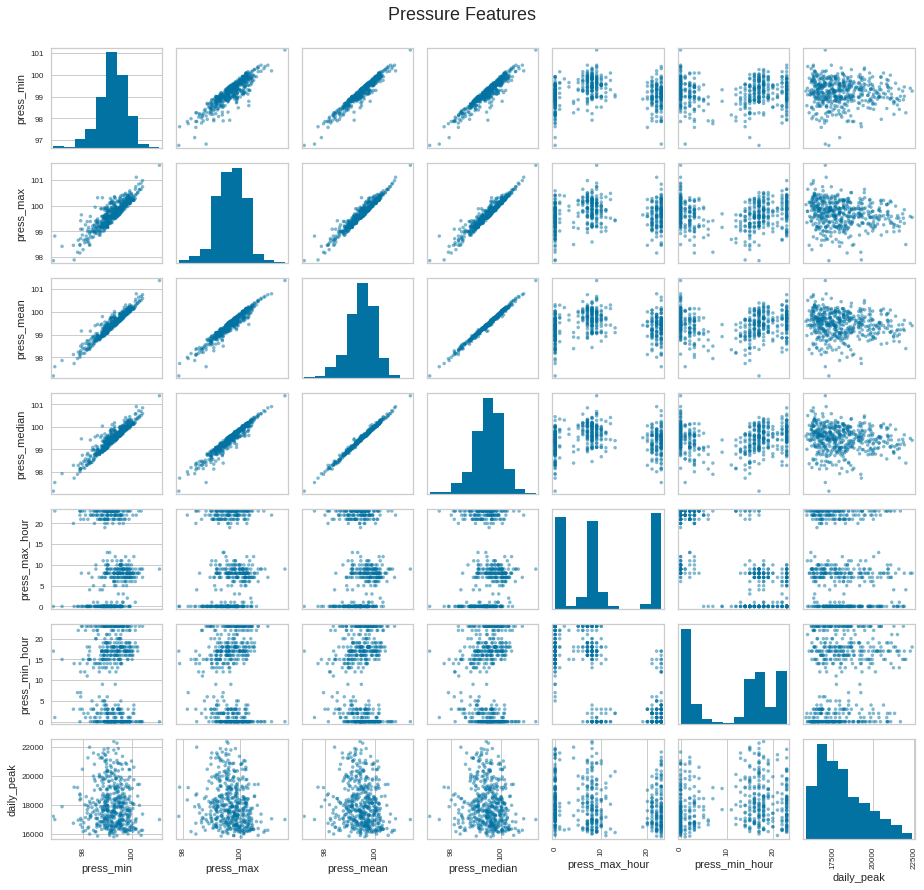

In [13]:
press_cols = [col for col in X.columns if 'press' in col[0:10]]
X_press = X[press_cols]
XP_press = pd.concat([X_press, y], axis=1)
pd.plotting.scatter_matrix(XP_press, figsize=(13,13));
plt.suptitle('Pressure Features', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show();

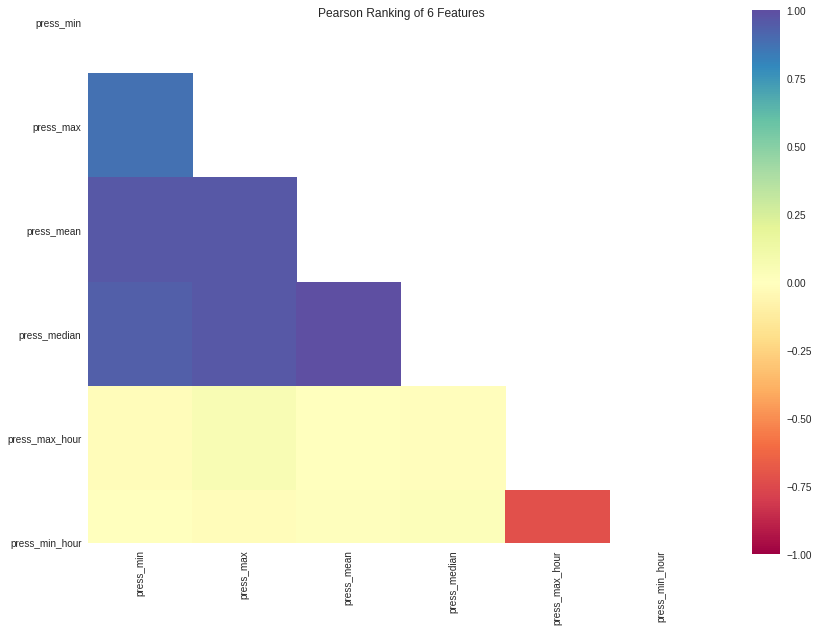

In [14]:
from yellowbrick.features import Rank2D
# Instantiate visualizer using Pearson ranking algorithm
figsize=(14, 10)
fig, ax = plt.subplots(figsize=figsize)
visualizer = Rank2D(features=press_cols, algorithm='pearson', colormap='Spectral')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

visualizer.fit(X_press, y)
visualizer.transform(X_press)
visualizer.poof();

There are a load of highly correlated variable in here

In [15]:
corr = X_press.corr()
corr.head(40)

,press_min,press_max,press_mean,press_median,press_max_hour,press_min_hour
press_min,1.000000,0.880796,0.962674,0.942667,-0.021581,0.006411
press_max,0.880796,1.000000,0.966074,0.963688,0.059604,-0.016627
press_mean,0.962674,0.966074,1.000000,0.995713,0.001868,0.009569
press_median,0.942667,0.963688,0.995713,1.000000,-0.008181,0.029192
press_max_hour,-0.021581,0.059604,0.001868,-0.008181,1.000000,-0.725883
press_min_hour,0.006411,-0.016627,0.009569,0.029192,-0.725883,1.000000


Explain later, but let's keep these - Disregard
+ Pressure Median

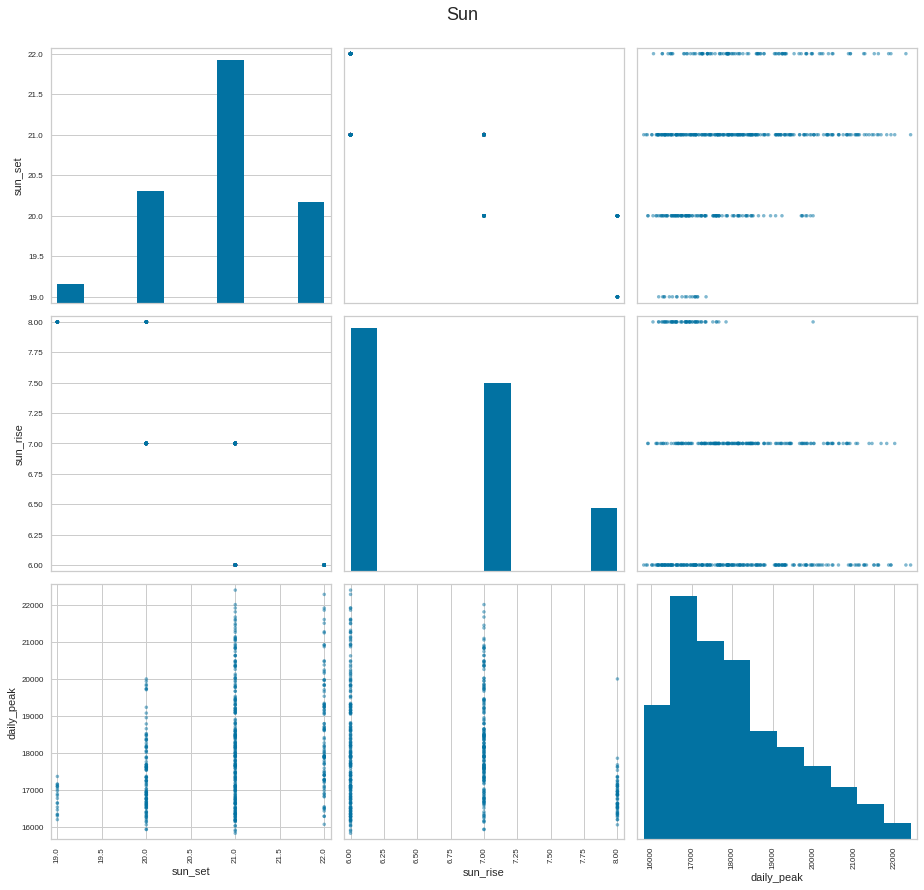

In [16]:
dp_temp_cols = [col for col in X.columns if 'sun' in col]
X_temp = X[dp_temp_cols]
XP_temp = pd.concat([X_temp, y], axis=1)
pd.plotting.scatter_matrix(XP_temp, figsize=(13,13));
plt.suptitle('Sun', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.savefig(NOTEBOOKS_DIR / 'saved-images' / 'humidex-features-correlation-plot.PNG')
plt.show();

## Categorical Features

In [17]:
df_day = pd.concat([X, y], axis=1)
df_day = df_day.loc['1998'][['year', 'week_of_year', 'day_of_week', 'daily_peak']].copy(deep=True)
df_day.drop_duplicates(inplace=True)
df_day.head(10)

,year,week_of_year,day_of_week,daily_peak
1998-05-19,1998.0,21.0,1.0,19816.0
1998-05-20,1998.0,21.0,2.0,19526.0
1998-05-21,1998.0,21.0,3.0,17061.0
1998-05-22,1998.0,21.0,4.0,16954.0
1998-05-25,1998.0,22.0,0.0,17930.0
1998-05-26,1998.0,22.0,1.0,17635.0
1998-05-27,1998.0,22.0,2.0,17992.0
1998-05-28,1998.0,22.0,3.0,19093.0
1998-05-29,1998.0,22.0,4.0,19303.0
1998-06-01,1998.0,23.0,0.0,17105.0


In [18]:
df_day = df_day.pivot(index='day_of_week', columns='week_of_year', values='daily_peak')
# create an arbitrary day to use as a datetime axis, so that we can use nice matplotlib labelling
df_day.index = pd.Index(df_day.index, name='representative days of all weeks')
df_day.head(8)


week_of_year,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0
representative days of all weeks,,,,,,,,,,,,,,,,,,,,
0.0,NaN,17930.0,17105.0,17436.0,19251.0,22287.0,21274.0,18171.0,20941.0,21314.0,18796.0,NaN,21451.0,21814.0,22011.0,19072.0,NaN,19229.0,19997.0,17621.0
1.0,19816.0,17635.0,17905.0,17633.0,18785.0,20917.0,19220.0,17887.0,21579.0,21492.0,20018.0,20628.0,20347.0,18458.0,20830.0,18649.0,17362.0,19731.0,17247.0,17671.0
2.0,19526.0,17992.0,16727.0,17456.0,19043.0,21917.0,NaN,18692.0,22403.0,21071.0,19366.0,19764.0,19328.0,17998.0,20436.0,18467.0,17232.0,18496.0,17130.0,17849.0
3.0,17061.0,19093.0,16869.0,17698.0,19528.0,21861.0,19097.0,19650.0,21918.0,20127.0,18147.0,19091.0,19461.0,18610.0,20837.0,18195.0,17664.0,18384.0,17336.0,17144.0
4.0,16954.0,19303.0,17028.0,18596.0,19703.0,21607.0,19149.0,17897.0,20085.0,17693.0,17800.0,19210.0,19664.0,20468.0,20341.0,17882.0,18779.0,18360.0,17522.0,16841.0


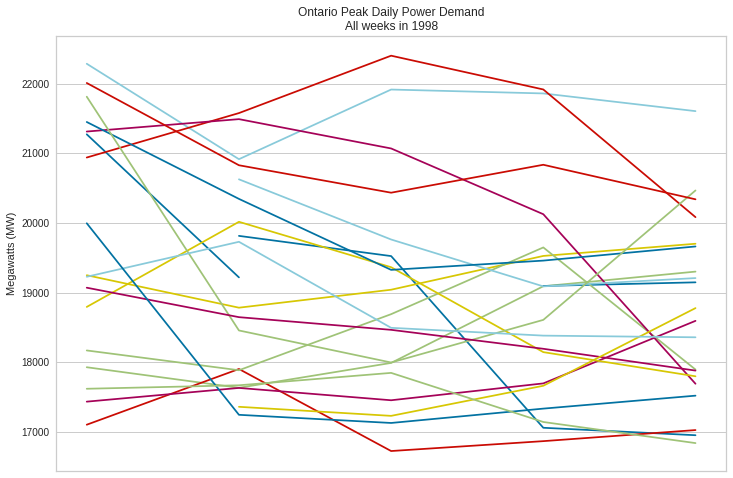

In [19]:
date_format = '%A'
mdates_locator = mdates.DayLocator()
labels = []
fig, ax = seasonal_plot(df_day,
                        labels=labels,
                        date_format=date_format,
                        mdates_locator=mdates_locator)
ax.set_title('Ontario Peak Daily Power Demand\nAll weeks in 1998')
ax.set_ylabel('Megawatts (MW)')
#ax.set_xlabel('Day of week')
plt.savefig('saved-images/ontario-peak-daily-power-demand-all-weeks-1998.PNG')
plt.show();

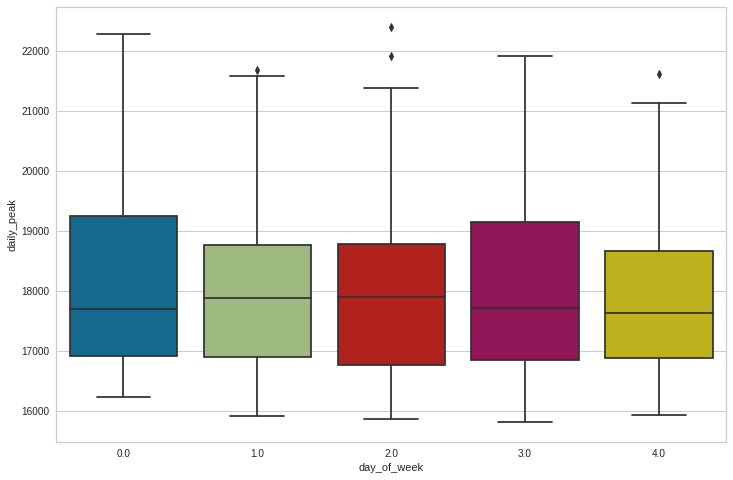

In [20]:
df_temp = pd.concat([X, y], axis=1)
fig, ax = plt.subplots(frameon=False, figsize=(12,8))
sns.boxplot(x= df_temp['day_of_week'], y = df_temp['daily_peak'], ax=ax)
plt.show();

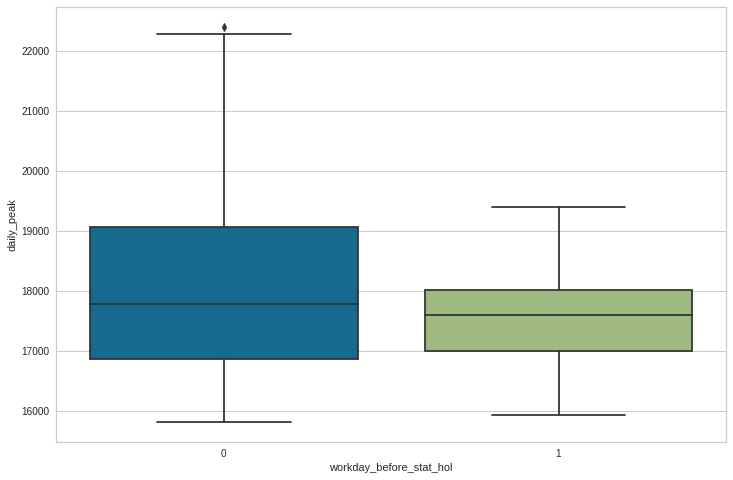

In [21]:
df_temp = pd.concat([X, y], axis=1)
fig, ax = plt.subplots(frameon=False, figsize=(12,8))
sns.boxplot(x= df_temp['workday_before_stat_hol'], y = df_temp['daily_peak'], ax=ax)
plt.show();

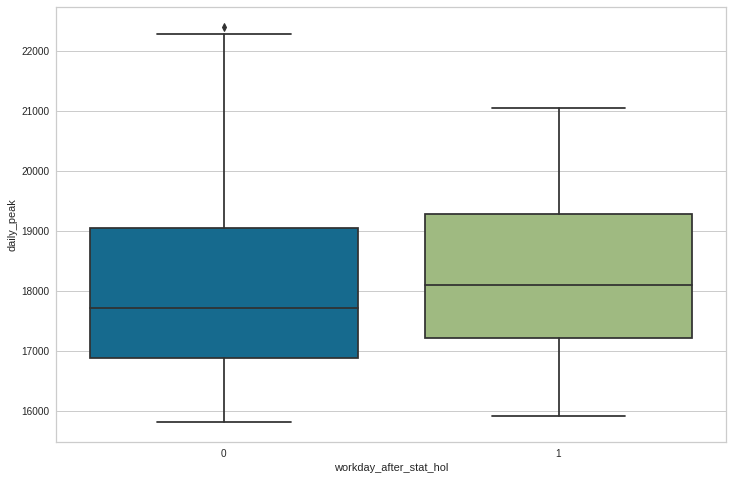

In [22]:
df_temp = pd.concat([X, y], axis=1)
fig, ax = plt.subplots(frameon=False, figsize=(12,8))
sns.boxplot(x= df_temp['workday_after_stat_hol'], y = df_temp['daily_peak'], ax=ax)
plt.show();

### Create a Feature For Day Type

+ Normal 0
+ Day Before Stat Hol 1
+ Day After Stat Hol 2

In [23]:
df_orig = pd.read_csv(CLEAN_DATA_DIR / 'daily.csv', index_col=0, parse_dates=True)
df_orig.head()

,temp_min,temp_max,temp_mean,temp_median,temp_max_hour,temp_min_hour,dew_point_temp_min,dew_point_temp_max,dew_point_temp_mean,dew_point_temp_median,dew_point_temp_max_hour,dew_point_temp_min_hour,rel_hum_min,rel_hum_max,rel_hum_mean,rel_hum_median,rel_hum_max_hour,rel_hum_min_hour,visibility_min,visibility_max,visibility_mean,visibility_median,visibility_max_hour,visibility_min_hour,press_min,press_max,press_mean,press_median,press_max_hour,press_min_hour,hmdxx_min,hmdxx_max,hmdxx_mean,hmdxx_median,hmdxx_max_hour,hmdxx_min_hour,sun_set,sun_rise,hmdxx_median-1,day_of_week,week_of_year,workday_before_stat_hol,workday_after_stat_hol,daily_peak,year
1994-05-24,9.0,19.6,14.300000,14.60,12.0,3.0,6.2,13.4,9.508333,8.95,18.0,11.0,42.0,92.0,75.083333,81.0,22.0,12.0,6.4,40.2,24.975000,24.55,5.0,8.0,98.52,99.39,99.045000,99.155,9.0,23.0,8.998045,19.818202,15.440330,17.205396,15.0,4.0,21.0,6.0,19.655075,1.0,21.0,0,1,16173.0,1994.0
1994-05-25,10.4,18.2,14.491667,14.95,16.0,2.0,9.4,14.0,11.825000,12.25,18.0,1.0,64.0,96.0,84.666667,87.0,2.0,16.0,6.4,12.9,9.358333,9.70,15.0,5.0,98.26,98.46,98.353125,98.360,0.0,17.0,11.406291,20.665711,16.695849,17.722172,18.0,3.0,21.0,6.0,17.205396,2.0,21.0,0,0,16017.0,1994.0
1994-05-26,3.9,13.0,8.037500,7.00,0.0,20.0,1.9,12.3,6.729167,5.80,5.0,22.0,81.0,97.0,91.416667,91.5,5.0,22.0,4.8,24.1,9.650000,8.85,23.0,5.0,97.89,99.09,98.295000,98.125,21.0,6.0,2.563201,15.259916,8.102568,6.567827,2.0,17.0,21.0,6.0,17.722172,3.0,21.0,0,0,16656.0,1994.0
1994-05-27,2.0,14.8,8.712500,8.70,16.0,3.0,-0.9,2.3,0.562500,0.40,14.0,15.0,36.0,95.0,59.833333,54.5,1.0,15.0,25.0,40.2,34.500000,40.20,5.0,0.0,99.12,99.52,99.392083,99.450,9.0,0.0,-0.012865,12.970553,6.695368,6.599016,17.0,3.0,21.0,6.0,6.567827,4.0,21.0,0,0,16252.0,1994.0
1994-05-30,13.1,27.2,20.850000,21.70,15.0,3.0,8.0,13.6,11.225000,12.40,14.0,5.0,40.0,74.0,55.375000,52.5,1.0,15.0,16.1,25.0,22.270833,24.10,0.0,1.0,99.39,99.62,99.519583,99.535,8.0,20.0,13.632519,30.133976,22.777217,23.590459,14.0,3.0,21.0,6.0,18.724332,0.0,22.0,0,0,16525.0,1994.0


In [24]:
df_orig['workday_after_stat_hol'] = df_orig['workday_after_stat_hol'].map({0:0, 1:2})
df_orig['day_type']= df_orig['workday_before_stat_hol'].add(df_orig['workday_after_stat_hol'])
df_orig.iloc[10:30]

,temp_min,temp_max,temp_mean,temp_median,temp_max_hour,temp_min_hour,dew_point_temp_min,dew_point_temp_max,dew_point_temp_mean,dew_point_temp_median,dew_point_temp_max_hour,dew_point_temp_min_hour,rel_hum_min,rel_hum_max,rel_hum_mean,rel_hum_median,rel_hum_max_hour,rel_hum_min_hour,visibility_min,visibility_max,visibility_mean,visibility_median,visibility_max_hour,visibility_min_hour,press_min,press_max,press_mean,press_median,press_max_hour,press_min_hour,hmdxx_min,hmdxx_max,hmdxx_mean,hmdxx_median,hmdxx_max_hour,hmdxx_min_hour,sun_set,sun_rise,hmdxx_median-1,day_of_week,week_of_year,workday_before_stat_hol,workday_after_stat_hol,daily_peak,year,day_type
1994-06-07,11.0,22.2,16.458333,15.85,15.0,21.0,7.8,15.2,12.429167,12.80,10.0,23.0,63.0,93.0,77.833333,80.5,6.0,11.0,8.0,25.0,15.904167,12.90,22.0,8.0,98.56,99.32,98.865000,98.825,23.0,0.0,11.508745,26.294429,19.022131,18.532139,15.0,20.0,21.0,6.0,18.620874,1.0,23.0,0,0,16625.0,1994.0,0
1994-06-08,7.2,16.8,12.183333,11.50,14.0,5.0,0.4,6.8,4.558333,5.20,0.0,18.0,36.0,88.0,62.166667,63.0,5.0,18.0,25.0,40.2,34.500000,40.20,5.0,0.0,99.39,99.79,99.658333,99.690,11.0,0.0,6.626910,15.363201,11.352600,10.793957,14.0,5.0,21.0,6.0,18.532139,2.0,23.0,0,0,15907.0,1994.0,0
1994-06-09,5.4,25.1,15.995833,16.70,16.0,5.0,2.9,10.3,6.137500,5.90,20.0,5.0,28.0,85.0,56.333333,53.5,2.0,15.0,25.0,40.2,34.500000,40.20,5.0,0.0,99.45,99.82,99.643750,99.670,3.0,15.0,4.022227,25.228666,15.739004,16.834478,16.0,5.0,21.0,6.0,10.793957,3.0,23.0,0,0,16357.0,1994.0,0
1994-06-10,9.2,21.6,16.245833,17.00,12.0,4.0,1.7,7.8,5.087500,5.40,12.0,22.0,36.0,78.0,49.625000,41.0,5.0,21.0,19.3,40.2,27.325000,25.00,5.0,2.0,99.65,99.95,99.791667,99.770,7.0,0.0,8.489480,21.927487,15.587726,15.897359,12.0,4.0,21.0,6.0,16.834478,4.0,23.0,0,0,16392.0,1994.0,0
1994-06-13,14.1,23.0,18.875000,19.50,15.0,3.0,12.7,18.8,15.820833,16.50,14.0,3.0,72.0,91.0,82.666667,82.5,3.0,15.0,6.4,32.2,18.850000,19.30,20.0,11.0,98.79,99.35,99.099167,99.140,4.0,17.0,16.732139,28.713368,23.429059,24.417829,15.0,3.0,22.0,6.0,22.343296,0.0,24.0,0,0,17288.0,1994.0,0
1994-06-14,16.6,25.5,19.937500,18.40,15.0,5.0,14.0,17.2,15.620833,16.15,15.0,9.0,58.0,97.0,77.291667,78.0,5.0,16.0,4.8,40.2,29.391667,40.20,7.0,5.0,99.02,99.79,99.442083,99.550,23.0,0.0,20.702955,30.927769,24.322356,23.048649,15.0,7.0,22.0,6.0,24.417829,1.0,24.0,0,0,17580.0,1994.0,0
1994-06-15,16.0,27.0,21.233333,20.70,13.0,5.0,14.0,20.3,17.087500,17.50,12.0,0.0,64.0,90.0,77.791667,79.5,5.0,15.0,6.4,12.9,8.500000,8.00,0.0,7.0,99.82,100.09,99.994167,100.005,8.0,0.0,19.602955,34.488016,26.658160,26.341354,13.0,5.0,22.0,6.0,23.048649,2.0,24.0,0,0,19239.0,1994.0,0
1994-06-16,18.7,32.5,25.654167,25.70,13.0,5.0,16.7,23.2,20.333333,21.15,19.0,5.0,52.0,90.0,73.916667,76.0,0.0,13.0,2.0,9.7,5.920833,6.40,13.0,5.0,99.89,100.19,100.044583,100.050,7.0,17.0,23.779867,42.173007,33.605428,34.476699,17.0,5.0,22.0,6.0,26.341354,3.0,24.0,0,0,20468.0,1994.0,0
1994-06-17,21.7,32.8,27.762500,27.80,17.0,4.0,18.4,21.3,20.016667,20.20,8.0,20.0,45.0,91.0,64.791667,60.0,4.0,16.0,4.8,25.0,17.516667,19.30,21.0,5.0,99.75,100.09,99.943750,99.950,7.0,19.0,29.353519,40.205959,35.361153,35.295497,17.0,4.0,22.0,6.0,34.476699,4.0,24.0,0,0,20918.0,1994.0,0
1994-06-20,15.6,25.5,21.266667,21.75,14.0,5.0,12.0,15.1,13.604167,13.50,7.0,17.0,45.0,87.0,63.166667,60.5,5.0,14.0,24.1,40.2,32.154167,28.60,9.0,7.0,99.12,100.09,99.692083,99.835,0.0,23.0,18.607639,28.186588,24.412125,25.025936,14.0,4.0,22.0,6.0,29.837563,0.0,25.0,0,0,19313.0,1994.0,0


## Summary

Features to keep:

+ Humidex
 + Daily Minimum
 + Daily Maximum
 + Median of the Previous Day
 + Hour of Day with Maximum Humidity


+ Temperature
 + Daily Minimum
 + Daily Maximum
 
 
+ Dew Point Temperature
 + Daily maximum
 

+ Lighting Load Related
 + Sunrise
 + Sunset
 + Mean Visibility
 

+ Calendar
 + Day of Week
 + Week of Year
 + Day Type (Before/After Stat Hol or other)
 

## Save Reduced Features

In [25]:
df_orig['hmdxx_range'] = df_orig.loc[:, 'hmdxx_max'] - df_orig.loc[:, 'hmdxx_min']
df_orig.head()

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


,temp_min,temp_max,temp_mean,temp_median,temp_max_hour,temp_min_hour,dew_point_temp_min,dew_point_temp_max,dew_point_temp_mean,dew_point_temp_median,dew_point_temp_max_hour,dew_point_temp_min_hour,rel_hum_min,rel_hum_max,rel_hum_mean,rel_hum_median,rel_hum_max_hour,rel_hum_min_hour,visibility_min,visibility_max,visibility_mean,visibility_median,visibility_max_hour,visibility_min_hour,press_min,press_max,press_mean,press_median,press_max_hour,press_min_hour,hmdxx_min,hmdxx_max,hmdxx_mean,hmdxx_median,hmdxx_max_hour,hmdxx_min_hour,sun_set,sun_rise,hmdxx_median-1,day_of_week,week_of_year,workday_before_stat_hol,workday_after_stat_hol,daily_peak,year,day_type,hmdxx_range
1994-05-24,9.0,19.6,14.300000,14.60,12.0,3.0,6.2,13.4,9.508333,8.95,18.0,11.0,42.0,92.0,75.083333,81.0,22.0,12.0,6.4,40.2,24.975000,24.55,5.0,8.0,98.52,99.39,99.045000,99.155,9.0,23.0,8.998045,19.818202,15.440330,17.205396,15.0,4.0,21.0,6.0,19.655075,1.0,21.0,0,2,16173.0,1994.0,2,10.820157
1994-05-25,10.4,18.2,14.491667,14.95,16.0,2.0,9.4,14.0,11.825000,12.25,18.0,1.0,64.0,96.0,84.666667,87.0,2.0,16.0,6.4,12.9,9.358333,9.70,15.0,5.0,98.26,98.46,98.353125,98.360,0.0,17.0,11.406291,20.665711,16.695849,17.722172,18.0,3.0,21.0,6.0,17.205396,2.0,21.0,0,0,16017.0,1994.0,0,9.259420
1994-05-26,3.9,13.0,8.037500,7.00,0.0,20.0,1.9,12.3,6.729167,5.80,5.0,22.0,81.0,97.0,91.416667,91.5,5.0,22.0,4.8,24.1,9.650000,8.85,23.0,5.0,97.89,99.09,98.295000,98.125,21.0,6.0,2.563201,15.259916,8.102568,6.567827,2.0,17.0,21.0,6.0,17.722172,3.0,21.0,0,0,16656.0,1994.0,0,12.696715
1994-05-27,2.0,14.8,8.712500,8.70,16.0,3.0,-0.9,2.3,0.562500,0.40,14.0,15.0,36.0,95.0,59.833333,54.5,1.0,15.0,25.0,40.2,34.500000,40.20,5.0,0.0,99.12,99.52,99.392083,99.450,9.0,0.0,-0.012865,12.970553,6.695368,6.599016,17.0,3.0,21.0,6.0,6.567827,4.0,21.0,0,0,16252.0,1994.0,0,12.983417
1994-05-30,13.1,27.2,20.850000,21.70,15.0,3.0,8.0,13.6,11.225000,12.40,14.0,5.0,40.0,74.0,55.375000,52.5,1.0,15.0,16.1,25.0,22.270833,24.10,0.0,1.0,99.39,99.62,99.519583,99.535,8.0,20.0,13.632519,30.133976,22.777217,23.590459,14.0,3.0,21.0,6.0,18.724332,0.0,22.0,0,0,16525.0,1994.0,0,16.501458


In [26]:
features = ['hmdxx_min',
            'hmdxx_max',
            'hmdxx_median-1',
            'hmdxx_max_hour',
            'temp_min',
            'temp_max',
            'dew_point_temp_max',
            'sun_rise',
            'sun_set',
            'visibility_mean',
            'day_of_week',
            'week_of_year',
            'day_type',
            'daily_peak']

In [27]:
df_features = df_orig[features]
df_features.head()

,hmdxx_min,hmdxx_max,hmdxx_median-1,hmdxx_max_hour,temp_min,temp_max,dew_point_temp_max,sun_rise,sun_set,visibility_mean,day_of_week,week_of_year,day_type,daily_peak
1994-05-24,8.998045,19.818202,19.655075,15.0,9.0,19.6,13.4,6.0,21.0,24.975000,1.0,21.0,2,16173.0
1994-05-25,11.406291,20.665711,17.205396,18.0,10.4,18.2,14.0,6.0,21.0,9.358333,2.0,21.0,0,16017.0
1994-05-26,2.563201,15.259916,17.722172,2.0,3.9,13.0,12.3,6.0,21.0,9.650000,3.0,21.0,0,16656.0
1994-05-27,-0.012865,12.970553,6.567827,17.0,2.0,14.8,2.3,6.0,21.0,34.500000,4.0,21.0,0,16252.0
1994-05-30,13.632519,30.133976,18.724332,14.0,13.1,27.2,13.6,6.0,21.0,22.270833,0.0,22.0,0,16525.0


In [28]:

df_features.to_csv(CLEAN_DATA_DIR / 'clean-features.csv')